# Car detection by YOLO algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
import os
import colorsys
import random
%matplotlib inline

## 1 - YOLO

### 1.1 Model

The yolo model takes an input image (shape (416, 416, 3)), after passing through a ConvNet (see below), output a feature vector of shape (13, 13, 5*(80+1+4))

In [2]:
yolo_model = tf.keras.models.load_model('model/yolov2.h5')

### 1.2 Reading classes and anchors file as list

In [3]:
with open("model/coco_classes.txt") as f:
    class_names = [c.strip() for c in f.readlines()]

anchors = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
anchors = np.array(anchors).reshape(-1, 2)

## 2 - Preprocessing

### 2.1 Converting image of any size to size of (416, 416)

In [4]:
def image_preprocessing(image_file):
    image = Image.open(image_file)
    image_resized = image.resize((416, 416), Image.ANTIALIAS)
    image_data = np.array(image_resized) / 255.
    image_data = np.expand_dims(image_data, 0)
    return image, image_data

## 3 - Postprocessing

### 3.1 Converting final layer from yolo model to box parameters

In [5]:
def post_processing(features, anchors, num_classes=80):
    """
    From the original paper:
    b_x = sigmoid(f_x) + c_x
    b_y = sigmoid(f_y) + c_y
    b_w = anchor_w * exp(f_w)
    b_h = anchor_h * exp(f_h)
    box_prob = sigmoid(f_box_prob)
    
    Input:
    features - final convolutional layer from yolo model, shape of (1, 13, 13, num_anchors*(1+4+80))
    anchors - (5, 2)
    
    Output:
    box_probs - (1, 13, 13, num_anchors, 1)
    box_sizes - (1, 13, 13, num_anchors, 4), each term in last dim corresponding (y1, x1, y2, x2)
    class_probs - (1, 13, 13, num_anchors, 80)
    """
    num_anchors = len(anchors)
    anchors = tf.constant(anchors, shape=[1, 1, 1, num_anchors, 2], dtype=features.dtype)

    dims = tf.shape(features)[1:3]
    h, w = dims[0], dims[1]
    h_index = tf.reshape(tf.tile(tf.range(h), [w]), [1, h, w, 1, 1])
    w_index = tf.transpose(h_index, [0, 2, 1, 3, 4]) # assuming h=w
    index = tf.cast(tf.concat([h_index, w_index], axis=-1), features.dtype)
    dims = tf.cast(tf.reshape(dims, [1, 1, 1, 1, 2]), features.dtype)
    features = tf.reshape(features, [-1, h, w, num_anchors, num_classes+5])

    box_xy = (tf.sigmoid(features[..., :2]) + index) / dims # unit: image.size
    box_wh = tf.exp(features[..., 2:4]) * anchors / dims # unit: image.size
    
    # convert center and corner representation
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)
    box_sizes = tf.concat([box_mins[..., 1:2], box_mins[..., 0:1], box_maxes[..., 1:2],box_maxes[..., 0:1]], -1)
    
    box_probs = tf.sigmoid(features[..., 4:5])
    class_probs = tf.nn.softmax(features[..., 5:])
    return box_probs, box_sizes, class_probs

### 3.2 Filtering boxes that have low scores and implementing non max suppression

In [6]:
def box_filter_and_nonmax_suppression(box_probs, box_sizes, class_probs, threshold=0.3, max_num_boxes=10):
    """ 
    Input:
    box_probs shape (1, 13, 13, 5, 1)
    box_sizes shape (1, 13, 13, 5, 4), each term corresponding to (y1, x1, y2, x2)
    class_probs shape (1, 13, 13, 5, 80)
    
    Output:
    scores shape (None,)
    box_sizes shape (None, 4)
    classes shape (None,)
    """
    box_scores = box_probs * class_probs
    scores = tf.reduce_max(box_scores, axis=-1)
    classes = tf.argmax(box_scores, axis=-1)
    mask = scores >= threshold
    box_sizes = tf.boolean_mask(box_sizes, mask)
    scores = tf.boolean_mask(scores, mask)
    classes = tf.boolean_mask(classes, mask)
    
    nonmax_indices = tf.image.non_max_suppression(box_sizes, scores, max_output_size=tf.constant(max_num_boxes), iou_threshold=0.5)
    box_sizes = tf.gather(box_sizes, nonmax_indices)
    scores = tf.gather(scores, nonmax_indices)
    classes = tf.gather(classes, nonmax_indices)
    
    return scores, box_sizes, classes

### 3.3 Drawing boxes

In [7]:
def draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors):
    
    w, h = image.size
    font = ImageFont.truetype('fonts/arial.ttf', size=np.ceil(2.5e-2 * h).astype('int32'))
    thickness = (w + h) // 400
    
    for i, n in list(enumerate(out_classes)):
        class_prediction = class_names[n]
        box = out_boxes[i]
        score = out_scores[i]
        
        draw = ImageDraw.Draw(image)
        
        top, left, bottom, right = box
        top = max(0, np.ceil(top * h).astype('int32'))
        left = max(0, np.ceil(left * w).astype('int32'))
        bottom = min(image.size[1], np.ceil(bottom * h).astype('int32'))
        right = min(image.size[0], np.ceil(right * w).astype('int32'))
        
        label = '{0:s} {1:.3f}'.format(class_prediction, score)
        labelsize = draw.textsize(label, font)
        
        for i in range(thickness):
            draw.rectangle([left+i, top+i, right-i, bottom-i], outline=colors[n])
        draw.rectangle([(left, top), (left+labelsize[0], top+labelsize[1])], fill=colors[n])
        
        draw.text((left+1, top+1), label, fill=(0,0,0), font=font)

In [8]:
def generate_color(class_names):
    n = len(class_names)
    hsv_tuples = [(x / n, 1., 1.) for x in range(n)]
    rgb_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0]*255), int(x[1]*255), int(x[2]*255)), rgb_tuples))
    random.seed(11100)
    random.shuffle(colors)
    random.seed(None)
    return colors

## 4 Making prediction

In [9]:
sess = tf.keras.backend.get_session()

In [10]:
def prediction(sess, image_file, box_prob_threshold=0.3):
    
    image, image_data = image_preprocessing("images/" + image_file)
    image_shape = [float(image.size[1]), float(image.size[0])]
    
    box_probs, box_sizes, class_probs = post_processing(yolo_model.output, anchors)
    scores, box_sizes, classes = box_filter_and_nonmax_suppression(box_probs, box_sizes, class_probs, box_prob_threshold)
    out_scores, out_boxes, out_classes = sess.run([scores, box_sizes, classes], feed_dict={yolo_model.input: image_data, tf.keras.backend.learning_phase(): 0})
    
    return image, out_scores, out_boxes, out_classes

In [11]:
def show_and_save_image(image_file, figsize=(16,16), box_prob_threshold=0.4):
    plt.figure(figsize=figsize)
    image, out_scores, out_boxes, out_classes = prediction(sess, image_file, box_prob_threshold)
    colors = generate_color(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    plt.imshow(image)
    plt.show()
    image.save(os.path.join('outputs/', image_file))

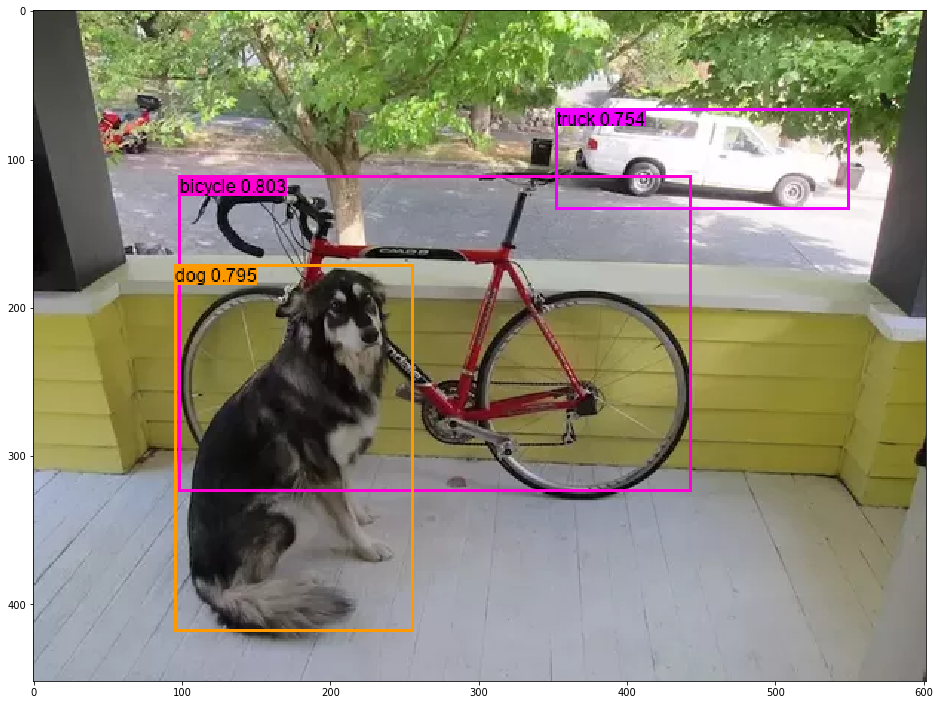

In [12]:
show_and_save_image('test.jpg', box_prob_threshold=0.4)